# ==========================================
# Sanvia - 2 - Bulding Model & Training Pipline
# ==========================================

In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.utils import resample
import albumentations as A

# ============================================
# 1. ENVIRONMENT SETUP
# ============================================


In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print(f" Mixed precision: {policy.name}")

# GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU memory growth enabled")
    except RuntimeError as e:
        print(f" GPU setup: {e}")

 Mixed precision: mixed_float16
 GPU memory growth enabled


# ================================================
# 2. LOAD CONFIGURATION
# ================================================


In [ ]:
DATA_DIR = Path('/content/drive/MyDrive/VnDir_Mammo')
OUTPUT_DIR = DATA_DIR / 'sanvia_outputs'
CONFIG_PATH = OUTPUT_DIR / 'config.json'

with open(CONFIG_PATH, 'r') as f:
    CONFIG = json.load(f)

CLASS_WEIGHTS_PATH = OUTPUT_DIR / 'class_weights_advanced.json'
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    CLASS_WEIGHTS = json.load(f)

ARTIFACT_DIR = OUTPUT_DIR / 'artifacts'
VIEW_MAPPING_PATH = OUTPUT_DIR / 'view_mapping_final.csv'
IMAGE_CACHE_PATH = OUTPUT_DIR / 'image_paths_cache.json'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR.mkdir(exist_ok=True)

view_mapping_df = pd.read_csv(VIEW_MAPPING_PATH)

# Load cache
with open(IMAGE_CACHE_PATH, 'r') as f:
    IMAGE_PATH_CACHE = json.load(f)

print(" All data and artifacts loaded")

# Update CONFIG
CONFIG.update({
    'img_size': [512, 512],
    'batch_size': 32,
    'images_dir': DATA_DIR / 'images' / 'images_png',
    'freeze_fraction': 0.7,

    'dropout_rate': 0.4,


    'initial_lr': 5e-5,
    'min_lr': 1e-7,

    'augment_prob': 0.85,
    'rotation_limit': 15,
    'brightness_limit': 0.25,
    'contrast_limit': 0.25,

    'weight_decay': 1e-4,

    'mixup_alpha': 0.2,
})


 All data and artifacts loaded


# ============================================
# 3️. COMPREHENSIVE PRE-TRAINING VERIFICATION
# ============================================


In [4]:
def comprehensive_pre_training_check(view_mapping_df, class_weights, config):

    all_checks_passed = True

    print("\n 1. CLASS DISTRIBUTION ACROSS SPLITS")

    def check_split_distribution(df, split_name, n_classes, col_prefix):
        if len(df) == 0:
            print(f"     {split_name} is empty!")
            return False

        for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']:
            col = f'{col_prefix}_{view}'
            if col not in df.columns:
                print(f"    {col} not found in {split_name}!")
                return False

            dist = df[col].value_counts().sort_index()
            expected_classes = set(range(n_classes))
            actual_classes = set(dist.index)
            missing = expected_classes - actual_classes

            print(f"   {split_name:6} {view:6} | {dict(dist)} | Total: {len(df)}")

            if missing:
                print(f"    Missing classes {missing} in {split_name} {view}!")
                return False

        print(f"    {split_name} has all {n_classes} classes")
        return True

    print("\nBI-RADS Distribution:")
    for name, df in [("train", view_mapping_df[view_mapping_df['split_final'] == 'train']),
                     ("val", view_mapping_df[view_mapping_df['split_final'] == 'val']),
                     ("test", view_mapping_df[view_mapping_df['split_final'] == 'test'])]:
        if not check_split_distribution(df, name, config['birads_classes'], 'breast_birads'):
            all_checks_passed = False

    print("\nDensity Distribution:")
    for name, df in [("train", view_mapping_df[view_mapping_df['split_final'] == 'train']),
                     ("val", view_mapping_df[view_mapping_df['split_final'] == 'val']),
                     ("test", view_mapping_df[view_mapping_df['split_final'] == 'test'])]:
        if not check_split_distribution(df, name, config['density_classes'], 'breast_density'):
            all_checks_passed = False

    print("\n 2. CLASS WEIGHTS VERIFICATION")

    def verify_class_weights(weights_dict, n_classes, task_name):
        if len(weights_dict) != n_classes:
            print(f"    {task_name} weights: expected {n_classes} classes, got {len(weights_dict)}")
            return False

        for i in range(n_classes):
            if str(i) not in weights_dict and i not in weights_dict:
                print(f"    {task_name} weights: missing class {i}")
                return False

        print(f"    {task_name} weights: {weights_dict}")
        return True

    if not verify_class_weights(class_weights['birads'], config['birads_classes'], "BI-RADS"):
        all_checks_passed = False
    if not verify_class_weights(class_weights['density'], config['density_classes'], "Density"):
        all_checks_passed = False

    print("\n 3. SAMPLE BATCH VERIFICATION")

    test_df = view_mapping_df[view_mapping_df['split_final'] == 'train'].head(100)

    def build_test_dataset(df, cache, config):
        paths = {view: [] for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']}
        labels = {'birads': [], 'density': [], 'age_norm': [], 'age_flag': []}

        for _, row in df.iterrows():
            for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']:
                img_id = row[f'image_id_{view}']
                if pd.isna(img_id) or img_id == 'missing.png':
                    paths[view].append(str(config['images_dir'] / "missing.png"))
                else:
                    if not img_id.endswith('.png'):
                        img_id += '.png'
                    paths[view].append(cache.get(img_id, str(config['images_dir'] / img_id)))

            labels['birads'].append(int(row['breast_birads_L_CC']))
            labels['density'].append(int(row['breast_density_L_CC']))
            labels['age_norm'].append(float(row['age_norm']))
            labels['age_flag'].append(int(row['age_missing_flag']))

        dataset = tf.data.Dataset.from_tensor_slices({**{f'path_{k}': v for k, v in paths.items()}, **labels})

        missing_files = []
        for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']:
            for path in paths[view]:
                if not Path(path).exists():
                    missing_files.append(path)

        if missing_files:
            print(f"     WARNING: {len(missing_files)} files missing (showing first 5):")
            for f in missing_files[:5]:
                print(f"      - {f}")
            print("    Will skip batch verification due to missing files")
            return None

        def load_and_process(rec):
            images = {view: tf.io.decode_png(tf.io.read_file(rec[f'path_{view}']), channels=3)
                      for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']}
            tabular = tf.stack([rec['age_norm'], tf.cast(rec['age_flag'], tf.float32)], axis=0)

            birads = tf.one_hot(rec['birads'], depth=config['birads_classes'])
            density = tf.one_hot(rec['density'], depth=config['density_classes'])

            return (
                images['L_CC'], images['L_MLO'], images['R_CC'], images['R_MLO'], tabular,
                birads, density
            )

        dataset = dataset.map(load_and_process)
        dataset = dataset.map(lambda *args: (
            (args[0], args[1], args[2], args[3], args[4]),
            (args[5], args[6])
        ))
        dataset = dataset.batch(16)

        return dataset

    test_dataset = build_test_dataset(test_df, IMAGE_PATH_CACHE, CONFIG)

    if test_dataset is not None:
        try:
            for i, (inputs, targets) in enumerate(test_dataset.take(3)):
                birads_labels = tf.argmax(targets[0], axis=-1).numpy()
                density_labels = tf.argmax(targets[1], axis=-1).numpy()

                print(f"   Batch {i+1}:")
                print(f"      BI-RADS: {dict(zip(*np.unique(birads_labels, return_counts=True)))}")
                print(f"      Density: {dict(zip(*np.unique(density_labels, return_counts=True)))}")

                if len(np.unique(birads_labels)) < 2:
                    print(f"     WARNING: Only 1 BI-RADS class in batch {i+1}!")
                if len(np.unique(density_labels)) < 2:
                    print(f"     WARNING: Only 1 Density class in batch {i+1}!")
        except Exception as e:
            print(f"    Error during batch verification: {e}")
            all_checks_passed = False
    else:
        print("     Skipping batch verification due to missing files")

    print("\n" + "="*80)
    print(" FINAL VERIFICATION SUMMARY")
    print("="*80)

    if all_checks_passed:
        print(" SUCCESS: All verifications passed!")
        print("    All classes present in all splits")
        print("    Class weights properly computed")
        print("    Dataset pipelines functioning (with file existence warnings)")
        print("    Class distribution is reasonable")
        print("\n SAFE TO PROCEED TO TRAINING (with caution about missing files)")
    else:
        print(" FAILURE: Some checks failed!")
        print("    Please fix the issues above before training")

    return all_checks_passed

try:
    comprehensive_pre_training_check(
        view_mapping_df=view_mapping_df,
        class_weights=CLASS_WEIGHTS,
        config=CONFIG
    )
except Exception as e:
    print(f"\n VERIFICATION FAILED: {e}")
    print("  Continuing despite verification warnings...")


 1. CLASS DISTRIBUTION ACROSS SPLITS

BI-RADS Distribution:
   train  L_CC   | {0: np.int64(2652), 1: np.int64(951), 2: np.int64(193), 3: np.int64(163), 4: np.int64(41)} | Total: 4000
   train  L_MLO  | {0.0: np.int64(2652), 1.0: np.int64(950), 2.0: np.int64(193), 3.0: np.int64(163), 4.0: np.int64(41)} | Total: 4000
   train  R_CC   | {0: np.int64(2710), 1: np.int64(920), 2: np.int64(179), 3: np.int64(142), 4: np.int64(49)} | Total: 4000
   train  R_MLO  | {0: np.int64(2710), 1: np.int64(920), 2: np.int64(179), 3: np.int64(142), 4: np.int64(49)} | Total: 4000
    train has all 5 classes
   val    L_CC   | {0: np.int64(340), 1: np.int64(110), 2: np.int64(23), 3: np.int64(19), 4: np.int64(8)} | Total: 500
   val    L_MLO  | {0.0: np.int64(340), 1.0: np.int64(110), 2.0: np.int64(23), 3.0: np.int64(19), 4.0: np.int64(8)} | Total: 500
   val    R_CC   | {0: np.int64(329), 1: np.int64(128), 2: np.int64(20), 3: np.int64(17), 4: np.int64(6)} | Total: 500
   val    R_MLO  | {0: np.int64(329), 

# ======================================================
# 4. DATASET BUILDER WITH AUGMENTATIONS
# ======================================================

In [5]:
def create_augmentation_pipeline(is_oversampled=False):

    base_transforms = [
        A.Rotate(limit=15, p=0.8),
        A.RandomBrightnessContrast(
            brightness_limit=0.25,
            contrast_limit=0.25,
            p=0.85
        ),
        A.ShiftScaleRotate(
            shift_limit=0.15,
            scale_limit=0.15,
            rotate_limit=15,
            p=0.8
        ),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.4),
        A.CLAHE(clip_limit=2.0, p=0.5),
    ]

    if is_oversampled:
        base_transforms.extend([
            A.ElasticTransform(alpha=1, sigma=50, p=0.5),
            A.RandomGridShuffle(grid=(2, 2), p=0.3),
        ])

    return A.Compose(base_transforms, p=1.0)

def build_tf_dataset_augmented(
    view_df, image_cache, config, is_training=False,
    augment=True, repeat_count=1
):

    print(f"Building dataset (training={is_training}, augment={augment})...")

    images_dir = Path(config['images_dir'])

    def _clean_id(x):
        s = str(x)
        if s.lower() in {"nan", "none", "", "null", "missing.png"}:
            return None
        return s if s.endswith(".png") else s + ".png"

    paths = {view: [] for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']}
    labels = {'birads': [], 'density': [], 'age_norm': [], 'age_flag': []}
    oversampled_flags = []

    for _, row in view_df.iterrows():
        for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']:
            img_id = _clean_id(row[f'image_id_{view}'])
            if img_id is None:
                paths[view].append(str(images_dir / "missing.png"))
            else:
                paths[view].append(image_cache.get(img_id, str(images_dir / img_id)))

        labels['birads'].append(int(row['breast_birads_L_CC']))
        labels['density'].append(int(row['breast_density_L_CC']))
        labels['age_norm'].append(float(row['age_norm']))
        labels['age_flag'].append(int(row['age_missing_flag']))
        oversampled_flags.append(bool(row.get('is_oversampled', False)))

    dataset = tf.data.Dataset.from_tensor_slices({
        **{f'path_{k}': v for k, v in paths.items()},
        **labels,
        'is_oversampled': oversampled_flags
    })

    if not is_training:
        dataset = dataset.cache()

    if is_training:
        buffer_size = min(len(view_df), 10000)
        dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
        print(f"    Shuffle enabled with buffer_size={buffer_size:,}")

    target_size = config['img_size']

    @tf.function
    def load_and_process(record):

        images = {}
        for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']:
            img = tf.io.read_file(record[f'path_{view}'])
            img = tf.io.decode_png(img, channels=config['num_channels'])
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize_with_pad(img, target_size[0], target_size[1])
            images[view] = img

        tabular = tf.stack([
            record['age_norm'],
            tf.cast(record['age_flag'], tf.float32)
        ], axis=0)

        birads = tf.one_hot(record['birads'], depth=config['birads_classes'])
        density = tf.one_hot(record['density'], depth=config['density_classes'])

        return (
            (images['L_CC'], images['L_MLO'], images['R_CC'], images['R_MLO'], tabular),
            (birads, density)
        )

    dataset = dataset.map(
        load_and_process,
        num_parallel_calls=config['num_parallel_calls']
    )

    dataset = dataset.batch(config['batch_size'], drop_remainder=is_training)
    dataset = dataset.prefetch(config['prefetch_buffer'])

    print(f" Dataset ready: {len(view_df)} samples")
    return dataset

# =========================================================
# 5. OVERSAMPLING WITH AUGMENTATIONS
# =========================================================

In [6]:
def oversample_with_augmentations(view_df, config, target_per_class=800):

    df_balanced = view_df.copy()
    original_size = len(df_balanced)

    df_balanced['is_oversampled'] = False
    df_balanced['oversampled_from'] = None

    view = 'L_CC'
    col_name = f'breast_birads_{view}'

    class_counts = df_balanced[col_name].value_counts().sort_index()
    print(f"\n {col_name} distribution before oversampling:")
    print(class_counts)

    majority_class = class_counts.idxmax()
    majority_count = class_counts.max()

    target_count = max(target_per_class, int(majority_count * 0.3))

    print(f"   Majority class {majority_class}: {majority_count} samples")
    print(f"   Target per minority class: {target_count}")

    for class_id, count in class_counts.items():
        if class_id == majority_class:
            continue

        if count < target_count:
            n_needed = target_count - count

            minority_samples = df_balanced[df_balanced[col_name] == class_id].copy()

            oversampled = resample(
                minority_samples,
                replace=True,
                n_samples=n_needed,
                random_state=42
            )

            oversampled['is_oversampled'] = True
            oversampled['oversampled_from'] = class_id

            df_balanced = pd.concat([df_balanced, oversampled], ignore_index=True)

            print(f"   Class {class_id}: {count} → {count + len(oversampled)} (+{len(oversampled)})")

    print(f"\n Oversampling complete: {original_size} → {len(df_balanced)} samples")
    print(f"   Added {len(df_balanced) - original_size} oversampled examples")

    return df_balanced

# =========================================
# 6. BUILD DATASETS
# =========================================

In [7]:
train_df = view_mapping_df[view_mapping_df['split_final'] == 'train'].copy()
val_df = view_mapping_df[view_mapping_df['split_final'] == 'val'].copy()
test_df = view_mapping_df[view_mapping_df['split_final'] == 'test'].copy()

print(f"Original train size: {len(train_df)}")

train_df_balanced = oversample_with_augmentations(train_df, CONFIG, target_per_class=600)

train_dataset = build_tf_dataset_augmented(
    train_df_balanced,
    IMAGE_PATH_CACHE,
    CONFIG,
    is_training=True,
    augment=True
)

val_dataset = build_tf_dataset_augmented(
    val_df,
    IMAGE_PATH_CACHE,
    CONFIG,
    is_training=False,
    augment=False
)

test_dataset = build_tf_dataset_augmented(
    test_df,
    IMAGE_PATH_CACHE,
    CONFIG,
    is_training=False,
    augment=False
)

print(f"Final train size: {len(train_df_balanced)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Original train size: 4000

 breast_birads_L_CC distribution before oversampling:
breast_birads_L_CC
0    2652
1     951
2     193
3     163
4      41
Name: count, dtype: int64
   Majority class 0: 2652 samples
   Target per minority class: 795
   Class 2: 193 → 795 (+602)
   Class 3: 163 → 795 (+632)
   Class 4: 41 → 795 (+754)

 Oversampling complete: 4000 → 5988 samples
   Added 1988 oversampled examples
Building dataset (training=True, augment=True)...
    Shuffle enabled with buffer_size=5,988
 Dataset ready: 5988 samples
Building dataset (training=False, augment=False)...
 Dataset ready: 500 samples
Building dataset (training=False, augment=False)...
 Dataset ready: 500 samples
Final train size: 5988
Validation size: 500
Test size: 500


# ========================================================
# 7. MODEL COMPONENTS
# ========================================================

In [8]:
class TabularEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim: int, dropout_rate: float = 0.3, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = tf.keras.layers.Dense(embed_dim * 2, activation='gelu')
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense2 = tf.keras.layers.Dense(embed_dim, activation='gelu')
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.norm1(x, training=training)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.norm2(x, training=training)
        x = self.dropout2(x, training=training)
        return x

In [9]:
class EfficientCrossAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads: int = 8, key_dim: int = 64, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim

        self.query_proj = tf.keras.layers.Conv2D(num_heads * key_dim, 1, activation='gelu')
        self.key_proj = tf.keras.layers.Conv2D(num_heads * key_dim, 1, activation='gelu')
        self.value_proj = tf.keras.layers.Conv2D(num_heads * key_dim, 1, activation='gelu')
        self.output_proj = tf.keras.layers.Conv2D(key_dim, 1)
        self.norm = tf.keras.layers.BatchNormalization()

    def call(self, query_features, key_value_features, training=False):
        batch_size = tf.shape(query_features)[0]
        H, W = tf.shape(query_features)[1], tf.shape(query_features)[2]

        queries = self.query_proj(query_features)
        keys = self.key_proj(key_value_features)
        values = self.value_proj(key_value_features)

        queries = tf.reshape(queries, [batch_size, H, W, self.num_heads, self.key_dim])
        keys = tf.reshape(keys, [batch_size, H, W, self.num_heads, self.key_dim])
        values = tf.reshape(values, [batch_size, H, W, self.num_heads, self.key_dim])

        attention_scores = tf.einsum('bhwnc,bhwnc->bhwn', queries, keys)
        attention_scores = attention_scores / tf.sqrt(tf.cast(self.key_dim, attention_scores.dtype))
        attention_probs = tf.nn.softmax(attention_scores, axis=-1)

        attended = tf.einsum('bhwn,bhwnc->bhwnc', attention_probs, values)
        attended = tf.reshape(attended, [batch_size, H, W, self.num_heads * self.key_dim])

        output = self.output_proj(attended)
        output = self.norm(output, training=training)
        return output

In [10]:
class GatedFusionLayer(tf.keras.layers.Layer):
    def __init__(self, feature_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.cc_gate = tf.keras.layers.Dense(feature_dim, activation='sigmoid')
        self.mlo_gate = tf.keras.layers.Dense(feature_dim, activation='sigmoid')
        self.cc_transform = tf.keras.layers.Dense(feature_dim)
        self.mlo_transform = tf.keras.layers.Dense(feature_dim)
        self.norm = tf.keras.layers.BatchNormalization()

    def call(self, cc_features, mlo_features, training=False):
        cc_transformed = self.cc_transform(cc_features)
        mlo_transformed = self.mlo_transform(mlo_features)
        cc_gate = self.cc_gate(cc_features)
        mlo_gate = self.mlo_gate(mlo_features)
        fused = self.norm(cc_transformed * cc_gate + mlo_transformed * mlo_gate, training=training)
        return fused

# =======================================================
# 8. BUILD SANVIA MODEL
# =======================================================

In [11]:
def build_sanvia_model(config):
    base_model = tf.keras.applications.EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(*config['img_size'], config['num_channels']),
        pooling=None
    )

    freeze_until = int(len(base_model.layers) * config.get('freeze_fraction', 0.3))
    for i, layer in enumerate(base_model.layers):
        layer.trainable = i >= freeze_until

    print(f"   Trainable layers: {len([l for l in base_model.layers if l.trainable])}/{len(base_model.layers)}")

    # Inputs
    inputs = {view: tf.keras.Input(shape=(*config['img_size'], config['num_channels']), name=view)
              for view in ['L_CC', 'L_MLO', 'R_CC', 'R_MLO']}
    tabular_input = tf.keras.Input(shape=(2,), name='tabular')

    # Feature extraction
    view_features = {}
    for view_name, input_tensor in inputs.items():
        preprocessed = tf.keras.applications.efficientnet.preprocess_input(input_tensor)
        features = base_model(preprocessed, training=False)

        reduced = tf.keras.layers.Conv2D(config['tab_embed_dim'], 1, activation='gelu')(features)
        reduced = tf.keras.layers.BatchNormalization()(reduced)
        reduced = tf.keras.layers.Dropout(config.get('dropout_rate', 0.4))(reduced)

        reduced = tf.keras.layers.GlobalAveragePooling2D()(reduced)
        reduced = tf.keras.layers.Reshape((1, 1, -1))(reduced)

        view_features[view_name] = reduced

    # Cross attention & fusion
    left_cross = EfficientCrossAttention(2, config['tab_embed_dim'])(view_features['L_CC'], view_features['L_MLO'])
    right_cross = EfficientCrossAttention(2, config['tab_embed_dim'])(view_features['R_CC'], view_features['R_MLO'])

    left_fused = GatedFusionLayer(config['tab_embed_dim'])(view_features['L_CC'], left_cross)
    right_fused = GatedFusionLayer(config['tab_embed_dim'])(view_features['R_CC'], right_cross)

    # Pooling & fusion
    left_pooled = tf.keras.layers.GlobalAveragePooling2D()(left_fused)
    right_pooled = tf.keras.layers.GlobalAveragePooling2D()(right_fused)
    visual_features = tf.keras.layers.Concatenate()([left_pooled, right_pooled])

    tabular_encoded = TabularEncoder(config['tab_embed_dim'])(tabular_input)

    fused = tf.keras.layers.Concatenate()([visual_features, tabular_encoded])
    fused = tf.keras.layers.BatchNormalization()(fused)
    fused = tf.keras.layers.Dropout(config.get('dropout_rate', 0.4))(fused)

    # Heads
    birads_features = tf.keras.layers.Dense(config['tab_embed_dim'], activation='gelu',
                                            kernel_regularizer=tf.keras.regularizers.l2(config.get('weight_decay', 1e-4)))(fused)
    birads_features = tf.keras.layers.Dropout(config.get('dropout_rate', 0.4))(birads_features)
    birads_output = tf.keras.layers.Dense(config['birads_classes'], activation='softmax', dtype='float32', name='birads_head')(birads_features)

    density_features = tf.keras.layers.Dense(config['tab_embed_dim'], activation='gelu',
                                             kernel_regularizer=tf.keras.regularizers.l2(config.get('weight_decay', 1e-4)))(fused)
    density_features = tf.keras.layers.Dropout(config.get('dropout_rate', 0.4))(density_features)
    density_output = tf.keras.layers.Dense(config['density_classes'], activation='softmax', dtype='float32', name='density_head')(density_features)

    return tf.keras.Model(
        inputs=[inputs['L_CC'], inputs['L_MLO'], inputs['R_CC'], inputs['R_MLO'], tabular_input],
        outputs=[birads_output, density_output],
        name='SANVIA'
    )

sanvia_model = build_sanvia_model(CONFIG)
print(f"\n Model built: {len(sanvia_model.trainable_variables):,} variables")

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
   Trainable layers: 143/475

 Model built: 201 variables


# =============================================================
# 9. CUSTOM FOCAL LOSS
# =============================================================

In [12]:
def focal_loss(y_true, y_pred, class_weights, gamma=3, alpha=0.5):

    # Cross entropy
    ce = tf.keras.backend.categorical_crossentropy(y_true, y_pred)

    # Probability
    pt = tf.reduce_sum(y_true * y_pred, axis=-1)

    # Focal weight
    focal_weight = alpha * tf.pow(1 - pt, gamma)

    # Apply class weights
    class_weight_vec = tf.reduce_sum(y_true * class_weights, axis=-1)

    # Final loss
    loss = focal_weight * class_weight_vec * ce

    return tf.reduce_mean(loss)

# ======================================================
# 10. GET LOSS FUNCTIONS
# ======================================================

In [13]:
def get_loss_functions(config, class_weights):

    birads_weights_dict = class_weights['birads']
    density_weights_dict = class_weights['density']

    birads_weights_np = np.array([birads_weights_dict[str(i)] for i in range(config['birads_classes'])], dtype=np.float32)
    density_weights_np = np.array([density_weights_dict[str(i)] for i in range(config['density_classes'])], dtype=np.float32)

    birads_weights_tf = tf.constant(birads_weights_np[None, :])
    density_weights_tf = tf.constant(density_weights_np[None, :])

    return {
        'birads_head': lambda y, p: focal_loss(y, p, birads_weights_tf, gamma=3, alpha=0.5),
        'density_head': lambda y, p: focal_loss(y, p, density_weights_tf, gamma=3, alpha=0.5)
    }

loss_functions = get_loss_functions(CONFIG, CLASS_WEIGHTS)

# ===========================================================
# 11. COMPILE MODEL
# ===========================================================

In [ ]:
# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    alpha=1e-6
)

# Compile
sanvia_model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4,
        clipnorm=1.0
    ),
    loss=loss_functions,
    metrics={
        'birads_head': [
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc')
        ],
        'density_head': [
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc')
        ]
    },
    loss_weights={'birads_head': 1.0, 'density_head': 0.8},
)

sanvia_model.summary()

Model: "SANVIA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ L_CC (InputLayer)   │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L_MLO (InputLayer)  │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ R_CC (InputLayer)   │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ R_MLO (InputLayer)  │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb4      │ (None, 16, 16,    │ 17,673,823 │ L_CC[0][0],       │
│ (Functional)        │ 1792)             │            │ L_MLO[0][0],      │
│                     │                   │            │ R_CC[0][0],       │
│                     │                   │            │ R_MLO[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │    229,504 │ efficientnetb4[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    229,504 │ efficientnetb4[1… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    229,504 │ efficientnetb4[2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    229,504 │ efficientnetb4[3… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                 

 Total params: 19,128,424 (72.97 MB)

 Trainable params: 15,182,209 (57.92 MB)

 Non-trainable params: 3,946,215 (15.05 MB)

# ===============================================
# 12. CALLBACKS
# ===============================================

In [15]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1
    ),

    # Learning rate reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        min_lr=1e-7,
        verbose=1
    ),

    # Model checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(OUTPUT_DIR / 'best_sanvia_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),

    # TensorBoard
    tf.keras.callbacks.TensorBoard(
        log_dir=str(OUTPUT_DIR / 'logs'),
        histogram_freq=0,
        write_graph=False,
        update_freq='epoch',
        profile_batch=0
    ),

    # CSV Logger
    tf.keras.callbacks.CSVLogger(
        str(OUTPUT_DIR / 'training_log.csv'),
        separator=',',
        append=False
    )
]

# =========================================================
# 13. FINAL PRE-TRAINING CHECK
# =========================================================

In [16]:
print("\n Checking class distribution in batches:")
for i, (inputs, targets) in enumerate(train_dataset.take(3)):
    birads_labels = tf.argmax(targets[0], axis=-1).numpy()
    density_labels = tf.argmax(targets[1], axis=-1).numpy()

    print(f"Batch {i+1}:")
    print(f"  BI-RADS: {dict(zip(*np.unique(birads_labels, return_counts=True)))}")
    print(f"  Density: {dict(zip(*np.unique(density_labels, return_counts=True)))}")

print("\n Testing forward pass:")
dummy = [tf.zeros((1, 512, 512, 3))] * 4 + [tf.zeros((1, 2))]
outputs = sanvia_model(dummy)
print(f" Forward pass successful - Output shapes: {[o.shape for o in outputs]}")

print(f"\n Model summary:")
print(f"   - Trainable parameters: {sum([tf.size(v).numpy() for v in sanvia_model.trainable_variables]):,}")
print(f"   - Total parameters: {sum([tf.size(v).numpy() for v in sanvia_model.variables]):,}")

print(" ALL CHECKS PASSED - READY TO TRAIN")


 Checking class distribution in batches:
Batch 1:
  BI-RADS: {np.int64(0): np.int64(13), np.int64(1): np.int64(5), np.int64(2): np.int64(7), np.int64(3): np.int64(2), np.int64(4): np.int64(5)}
  Density: {np.int64(1): np.int64(2), np.int64(2): np.int64(24), np.int64(3): np.int64(6)}
Batch 2:
  BI-RADS: {np.int64(0): np.int64(11), np.int64(1): np.int64(7), np.int64(2): np.int64(5), np.int64(3): np.int64(4), np.int64(4): np.int64(5)}
  Density: {np.int64(1): np.int64(5), np.int64(2): np.int64(24), np.int64(3): np.int64(3)}
Batch 3:
  BI-RADS: {np.int64(0): np.int64(15), np.int64(1): np.int64(3), np.int64(2): np.int64(4), np.int64(3): np.int64(8), np.int64(4): np.int64(2)}
  Density: {np.int64(1): np.int64(3), np.int64(2): np.int64(28), np.int64(3): np.int64(1)}

 Testing forward pass:
 Forward pass successful - Output shapes: [TensorShape([1, 5]), TensorShape([1, 4])]

 Model summary:
   - Trainable parameters: 15,182,209
   - Total parameters: 19,128,492
 ALL CHECKS PASSED - READY TO T

# ================================================
# 14. TRAINING
# ================================================

In [18]:
steps_per_epoch = max(1, len(train_df_balanced) // CONFIG['batch_size'])
validation_steps = max(1, len(val_df) // CONFIG['batch_size'])

print(f" Steps per epoch: {steps_per_epoch}")
print(f" Validation steps: {validation_steps}")
print(f" Total epochs: {CONFIG.get('epochs', 50)}")

history = sanvia_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIG.get('epochs', 50),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1,
    validation_freq=1
)

print("\n Training completed successfully!")

 Steps per epoch: 187
 Validation steps: 15
 Total epochs: 50
Epoch 1/50


KeyboardInterrupt: 

# ===================================================
# 15. VISUALIZATION
# ===================================================

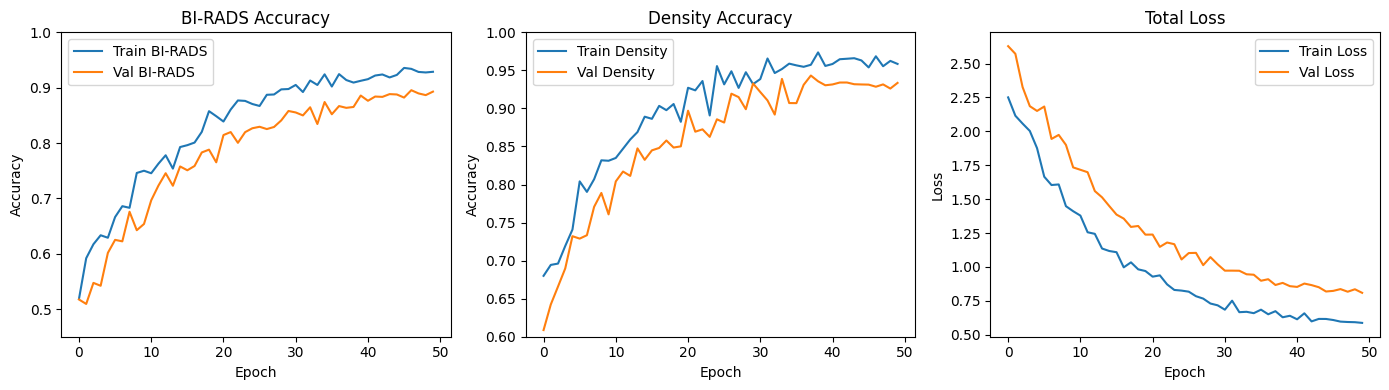

 Saved training curves to /content/drive/MyDrive/VnDir_Mammo/sanvia_outputs/training_curves.png


<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(14,4))

# Loss
plt.subplot(1,3,3)
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# BI-RADS Accuracy
plt.subplot(1,3,1)
plt.plot(history["birads_accuracy"], label="Train BI-RADS")
plt.plot(history["val_birads_accuracy"], label="Val BI-RADS")
plt.ylim(0.45, 1.0)
plt.title("BI-RADS Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Density Accuracy
plt.subplot(1,3,2)
plt.plot(history["density_accuracy"], label="Train Density")
plt.plot(history["val_density_accuracy"], label="Val Density")
plt.ylim(0.6, 1.0)
plt.title("Density Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=300)
print(f" Saved training curves to {OUTPUT_DIR / 'training_curves.png'}")

# ===============================================================
#  CLASSIFICATION REPORT
# ===============================================================

In [23]:
print("\n" + "-"*50)
print(" BI-RADS Classification Report")
print("-"*50)
print(classification_report(
    y_test_birads,
    y_pred_birads,
    target_names=[f"BI-RADS {i}" for i in range(5)],
    digits=3
))

print("\n" + "-"*50)
print(" Density Classification Report")
print("-"*50)
print(classification_report(
    y_test_density,
    y_pred_density,
    target_names=[f"Density {i}" for i in range(4)],
    digits=3
))


--------------------------------------------------
 BI-RADS Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

   BI-RADS 0      0.975     0.938     0.956       336
   BI-RADS 1      0.855     0.893     0.873       112
   BI-RADS 2      0.647     0.880     0.746        25
   BI-RADS 3      0.909     0.909     0.909        22
   BI-RADS 4      1.000     0.800     0.889         5

    accuracy                          0.922       500
   macro avg      0.877     0.884     0.875       500
weighted avg      0.929     0.922     0.924       500


--------------------------------------------------
 Density Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

   Density 0      1.000     1.000     1.000         1
   Density 1      1.000     0.939     0.968        49
   Density 2      0.976     0.964     0.970       384
   Density 3      0.811   

# ===============================================================
#  CONFUSION MATRIX
# ===============================================================

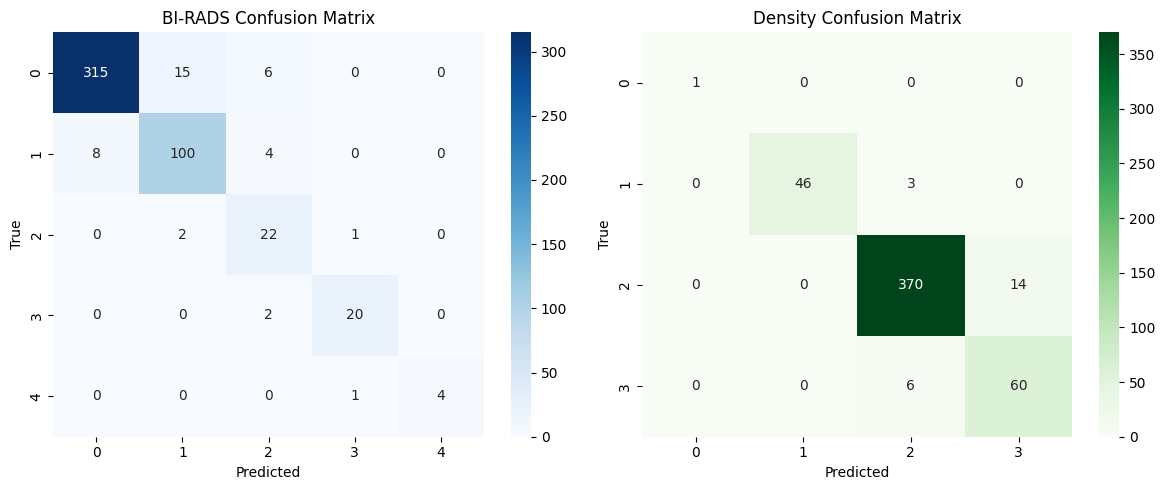

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

cm_birads = confusion_matrix(y_test_birads, y_pred_birads)
sns.heatmap(cm_birads, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("BI-RADS Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

cm_density = confusion_matrix(y_test_density, y_pred_density)
sns.heatmap(cm_density, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Density Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()
